# South Australia Crime Data 
## Data 
Data is courtesy of **South Australian Government Data Directory & SAPOL**. 

[CRIME DATA](https://data.sa.gov.au/data/dataset/crime-statistics) 
[SUBURB DATA](https://data.sa.gov.au/data/dataset/suburb-boundaries/resource/58b3b8ef-f292-4e27-a7bc-215ad7670cda)

## Problem
Clean, Visualise and identify South Australian Crime data trends

### Cleaning: Will be split into three categoties
1. **Data exploring:** Understanding the data, noting any changes that need to be implmented on the data and identifying patterns, elements and relationships
2. **Data Filtering:** remove record that wont be useful downstream
3. **Data Cleaning:** remove as much noise as possible

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import datetime
import plotly.express as px

In [233]:
data_crime = pd.read_csv('resources/2018-19-data_sa_crime.csv')
data = pd.DataFrame(data_crime)
data['Reported Date'] = pd.to_datetime(data['Reported Date'])
data_suburb = pd.read_csv('resources/SASuburbs.csv')
suburb = pd.DataFrame(data_suburb)
data.head()


,Reported Date,Suburb - Incident,Postcode - Incident,Offence Level 1 Description,Offence Level 2 Description,Offence Level 3 Description,Offence count
0,2018-01-07,ABERFOYLE PARK,5159,OFFENCES AGAINST PROPERTY,THEFT AND RELATED OFFENCES,Theft from motor vehicle,1.0
1,2018-01-07,ADELAIDE,5000,OFFENCES AGAINST PROPERTY,PROPERTY DAMAGE AND ENVIRONMENTAL,Other property damage and environmental,1.0
2,2018-01-07,ADELAIDE,5000,OFFENCES AGAINST PROPERTY,THEFT AND RELATED OFFENCES,Other theft,5.0
3,2018-01-07,ADELAIDE,5000,OFFENCES AGAINST PROPERTY,THEFT AND RELATED OFFENCES,Receive or handle proceeds of crime,1.0
4,2018-01-07,ADELAIDE,5000,OFFENCES AGAINST PROPERTY,THEFT AND RELATED OFFENCES,Theft from motor vehicle,1.0


# Locate missing data 
Locate missing data using the python funciton `isnull()`, which will identify every where within our data set where there is missing values.This function will return a list where `True` indicates a missing value. We then use the `sum()` function will return the number of missing elements per column 

In [3]:
data.isnull().sum()

Reported Date                    1
Suburb - Incident              197
Postcode - Incident            373
Offence Level 1 Description      1
Offence Level 2 Description      1
Offence Level 3 Description      1
Offence count                    1
dtype: int64

# Cleaning
Looking at the above table, it is evident that the key columns of this data set are:
1. Reported Date 
2. Postcode - Incident
3. Offence Level 1 Description
4. Offence count

## Replacing missing data
- Missing data within the *Suburb - Incident* row can be filled assuming the post code is known. 

- We will not be filling *Postcode - Incident* information that is missing as multiple postcodes can have the same or differnt suburb name i.e. *Postcode - Incident* is an **identifier** where as *Suburb - Incident* is an **identity**

# Removing data
- Any column which is missing the aforementioned four missing values will be removed as they are critical to this analysis


In [4]:
# remove empty row
remove = ['Suburb - Incident','Reported Date','Offence count','Offence Level 1 Description']
data.dropna(subset=remove, inplace=True)
data.isnull().sum()

Reported Date                    0
Suburb - Incident                0
Postcode - Incident            182
Offence Level 1 Description      0
Offence Level 2 Description      0
Offence Level 3 Description      0
Offence count                    0
dtype: int64

# Clean suburbs data 
The suburbs datas set only needs two rows, being the zipcode row and the suburb name row.


In [5]:
suburb.head()

,_id,postcode,suburb,suburb_num,legalstart,shape_Leng,shape_Area
0,1,872,AMATA,87206,00000000,0.258469,0.003274
1,2,872,ANANGU PITJANTJATJARA YANKUNYTJATJARA,87205,00000000,16.039186,9.288729
2,3,872,AYERS RANGE SOUTH,87202,26/04/2013,1.466852,0.117333
3,4,872,DE ROSE HILL,87201,26/04/2013,1.685673,0.167839
4,5,872,IWANTJA,87209,00000000,0.143976,0.001144


In [6]:
# remove the following columns, becayse we dont need them
remove = ['_id','suburb_num','legalstart','shape_Leng','shape_Area']
suburb.drop(remove, inplace = True, axis =1)
suburb.head()

,postcode,suburb
0,872,AMATA
1,872,ANANGU PITJANTJATJARA YANKUNYTJATJARA
2,872,AYERS RANGE SOUTH
3,872,DE ROSE HILL
4,872,IWANTJA


In [7]:
#check there are no missing values in the data
suburb.isnull().sum()

postcode    0
suburb      0
dtype: int64

# Update Missing Data 
Here we will add zipcodes to all missing suburbs within our `data` dataframe.

To do this we create transform the `subrurb` dataframe into a dictionary where the key is the suburb name and the value is the suburb postcode.


In [8]:
suburb_titles = list(suburb.columns)
suburb_titles

['postcode', 'suburb']

In [9]:
# swap titles
suburb_titles[0], suburb_titles[1] = suburb_titles[1], suburb_titles[0]
suburb_titles

['suburb', 'postcode']

In [10]:
# swap order of data 
suburb = suburb[suburb_titles]
suburb

,suburb,postcode
0,AMATA,872
1,ANANGU PITJANTJATJARA YANKUNYTJATJARA,872
2,AYERS RANGE SOUTH,872
3,DE ROSE HILL,872
4,IWANTJA,872
...,...,...
1888,MULOORINA,5733
1889,MUNDOWDNA,5733
1890,MUNGERANIE,5733
1891,CROWN POINT,5734


In [11]:
#convert suburb dataframe into dictionary
dic_suburb = suburb.set_index('suburb').to_dict()['postcode']

In [12]:
# add zipcodes to suburbs
for index, row in data.iterrows():
    if pd.isnull(data.loc[index, 'Postcode - Incident']) == True:
        #replace postcode NAN @ index, with the value of key Suburb
        data.replace({row['Postcode - Incident'], index},dic_suburb[row['Suburb - Incident']], inplace=True)
        

In [13]:
# check for duplicates
data.duplicated().sum()

0

# Normalising Data
ensure all data is in the same format i.e. case size

In [14]:
data_titles = list(data.columns)
#data_titlesNormalising

In [15]:
data['Suburb - Incident'] = data['Suburb - Incident'].str.upper()
data['Offence Level 1 Description'] = data['Offence Level 1 Description'].str.upper()
data['Offence Level 2 Description'] = data['Offence Level 2 Description'].str.upper()
data['Offence Level 3 Description'] = data['Offence Level 3 Description'].str.upper()
data['Offence count'] = data['Offence count'].astype(int)
#data['Postcode - Incident']= data['Postcode - Incident'].astype(int)

In [16]:
display(data.dtypes)

Reported Date                  object
Suburb - Incident              object
Postcode - Incident            object
Offence Level 1 Description    object
Offence Level 2 Description    object
Offence Level 3 Description    object
Offence count                   int32
dtype: object

In [17]:
data.head()

,Reported Date,Suburb - Incident,Postcode - Incident,Offence Level 1 Description,Offence Level 2 Description,Offence Level 3 Description,Offence count
0,1/07/2018,ABERFOYLE PARK,5159,OFFENCES AGAINST PROPERTY,THEFT AND RELATED OFFENCES,THEFT FROM MOTOR VEHICLE,1
1,1/07/2018,ADELAIDE,5000,OFFENCES AGAINST PROPERTY,PROPERTY DAMAGE AND ENVIRONMENTAL,OTHER PROPERTY DAMAGE AND ENVIRONMENTAL,1
2,1/07/2018,ADELAIDE,5000,OFFENCES AGAINST PROPERTY,THEFT AND RELATED OFFENCES,OTHER THEFT,5
3,1/07/2018,ADELAIDE,5000,OFFENCES AGAINST PROPERTY,THEFT AND RELATED OFFENCES,RECEIVE OR HANDLE PROCEEDS OF CRIME,1
4,1/07/2018,ADELAIDE,5000,OFFENCES AGAINST PROPERTY,THEFT AND RELATED OFFENCES,THEFT FROM MOTOR VEHICLE,1


# Get the number of crimes per-Offence Level 2 Description 
#### note that the figrues show below are only the top 500 data value of thousands
**Bar chart:** visualise how many offences are commited per offence. This shows how may offences were commited in the year 2018-2019

**Pie chart:** visualises the distribution of the crimes against each other

In [18]:
# returns all the descriptions as an array
crimeDescription = data[:500]['Offence Level 2 Description'].unique()
# returns offences as a 2d array
crimeOffenceCount2d = pd.DataFrame(data[:500].groupby(['Offence Level 2 Description'])['Offence count'].sum())
# convert 2d array to 1d
crimeOffenceCount = np.array(crimeOffenceCount2d).flatten()

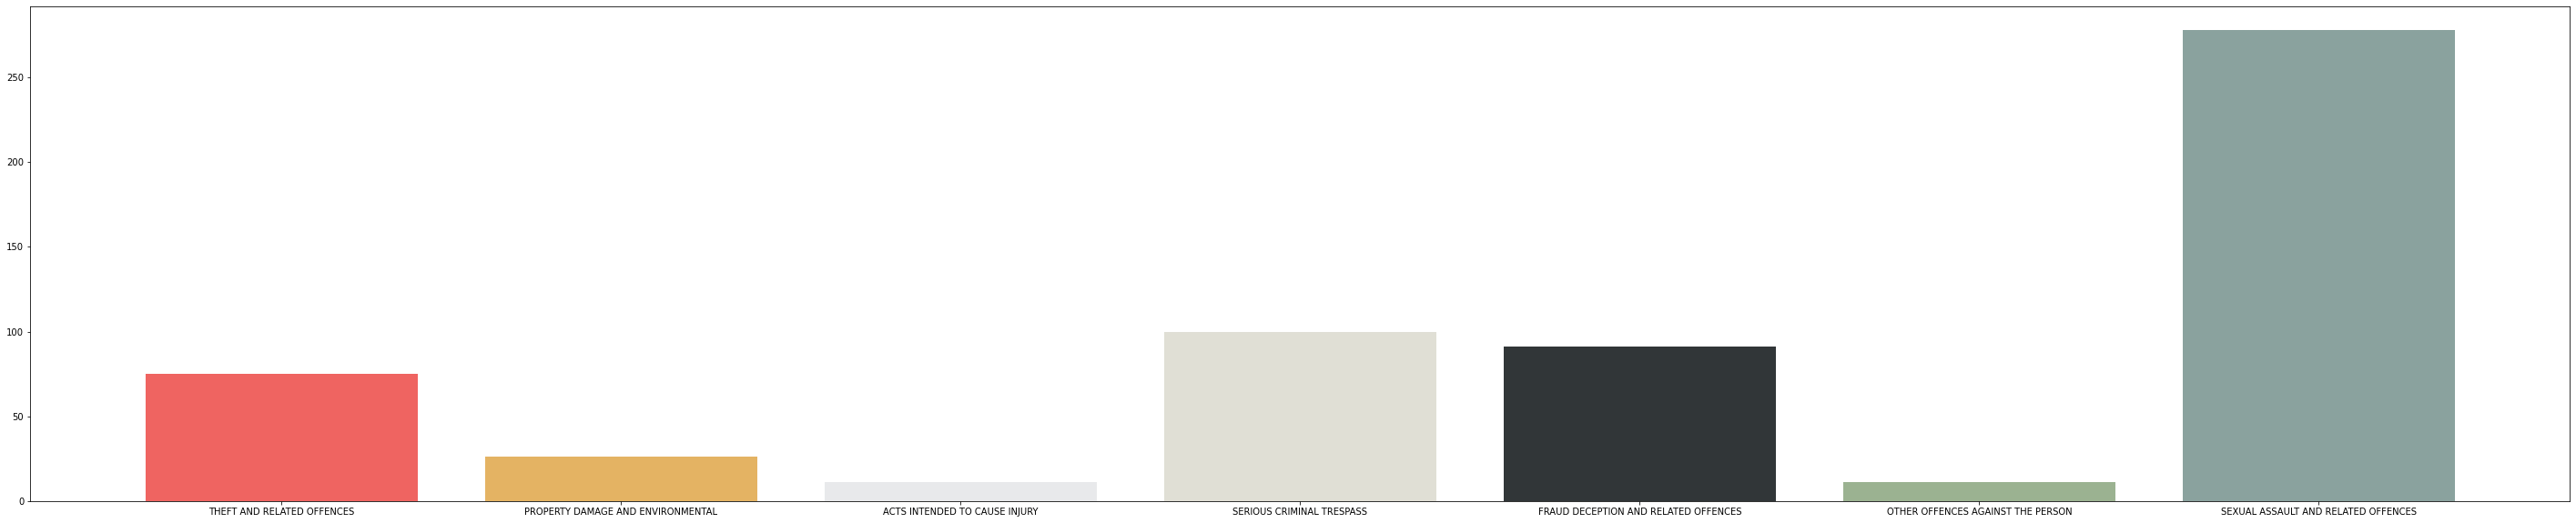

In [19]:
# update figure size 
plt.rcParams['figure.figsize'] = (50,10)
colour=['#EF6461','#e4b363','#e8e9eb','#e0dfd5','#313638','#9bb291','#8aa29e']
plt.bar(crimeDescription, crimeOffenceCount,color=colour )
# Show graph
plt.show()

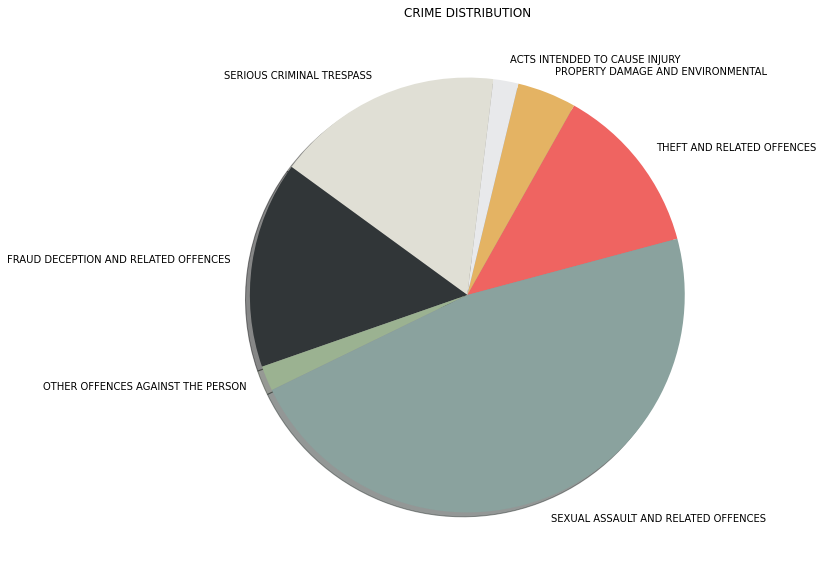

In [20]:
# update figure size 
plt.rcParams['figure.figsize'] = (20,10)
# plot crime in bar chart
my_explode = (0, 0.1, 0)
plt.pie(crimeOffenceCount, labels=crimeDescription, colors=colour, startangle=15, shadow = True)
plt.title('CRIME DISTRIBUTION')
plt.show()

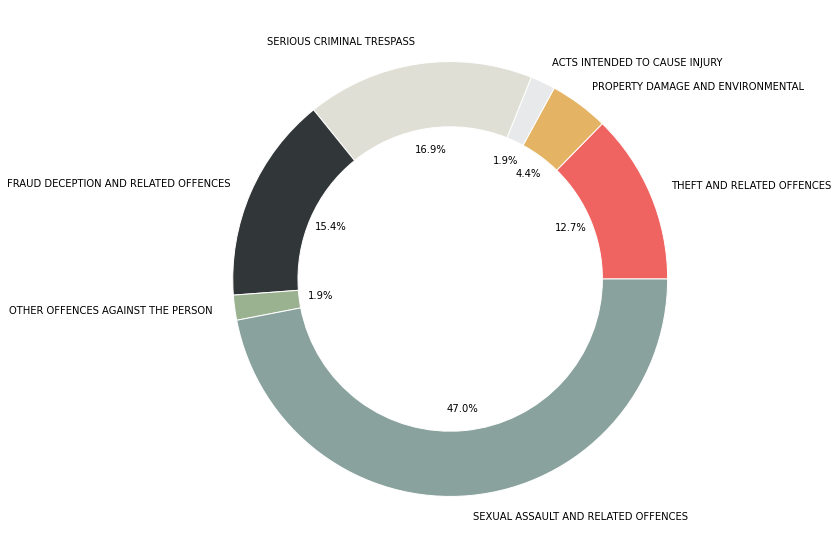

In [21]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (20,10)
ax.pie(crimeOffenceCount,labels=crimeDescription, radius=1, autopct='%1.1f%%', colors=colour,
       wedgeprops=dict(width=0.3, edgecolor='w'))
plt.show()

# Crime over the year
The visualisation below illustrates the number of crimes commited in the year.

**line chart** shows offences over the year

**lollipop chart** shows offences per month

In [22]:
# get offence months
month = pd.DataFrame(data.groupby(pd.to_datetime(data['Reported Date'])))
month = pd.DataFrame(month.groupby(month[0].dt.month_name()))
# get the total number of offences per month
monthlyOffence = pd.DataFrame(data.groupby(pd.to_datetime(data['Reported Date']).dt.month_name())['Offence count'].sum())
monthlyOffence

,Offence count
Reported Date,
April,9075
August,9485
December,9163
February,8822
January,9259
July,8936
June,9448
March,9801
May,9809


# Monthly total offences 2018-2020
Crime on a linear time line from April(first recorded offence month) to september (last recorded offence month). Where the number of offences permonth are recorded. The table below shows us that offences are at their highest point from july until november, maxing out in march to may. February has the lowest recorded number of offences.

In [ ]:
# get the unuqie crime descriptions as a dataframe and turn it into an aray
uniqueCrime = pd.DataFrame(data['Offence Level 2 Description'].unique())
uniqueCrime = np.array(uniqueCrime).flatten()

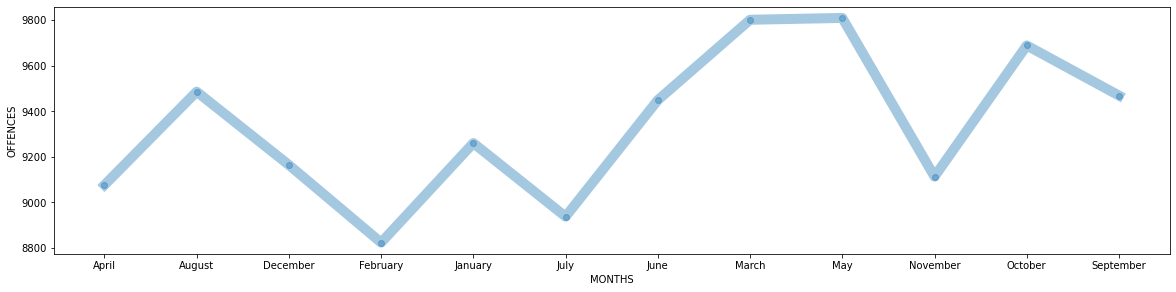

In [23]:
# total monthly offences
plt.rcParams['figure.figsize'] = (20,10)
plt.subplot(211)
plt.plot_date(month[0], monthlyOffence, linestyle='solid', alpha=0.4, linewidth=10)
plt.xlabel('MONTHS')
plt.ylabel('OFFENCES')
plt.show()

In [151]:
data['Reported Date'] = pd.to_datetime(data['Reported Date']) - pd.to_timedelta(7, unit='d')
# record data quarderly 
weeklyOffences = data.groupby(['Offence Level 2 Description', pd.Grouper(key='Reported Date', freq='Q')])['Offence count'].sum().reset_index().sort_values('Reported Date')
weeklyOffences.head()


,Offence Level 2 Description,Reported Date,Offence count
0,ACTS INTENDED TO CAUSE INJURY,2017-12-31,463.0
62,SEXUAL ASSAULT AND RELATED OFFENCES,2017-12-31,66.0
53,SERIOUS CRIMINAL TRESPASS,2017-12-31,492.0
26,OTHER OFFENCES AGAINST THE PERSON,2017-12-31,69.0
18,HOMICIDE AND RELATED OFFENCES,2017-12-31,1.0


# Quarterly Offences
Property damage and theft are the most common offences each qurter. Totallying close to two thids of all offences per quater. intrestingly the numberof offences commited between Jan 2019 and Jul 2019 are the highest total which is to be exected as there is a corrlation between summer months and a hightened crime rate. The reason we do not see this repliated in Jan 2020 is because that is when COVID-19 was first discovered.

In [160]:
long_df = px.data.medals_long()
fig = px.bar(weeklyOffences, x="Reported Date", y="Offence count", color='Offence Level 2 Description', title="South Australia Quarterly Offences (Jan, 2018 - 2020)")
fig.show()

# cumulative offences offences


In [266]:
tempWeeklyOffencesCumulative = data
# these are the coloumns we will use to visualise the comulative weekly offences
cumulativeColumns = ['Reported Date']
#offence = 'THEFT AND RELATED OFFENCES'

for offence in uniqueCrime:
    cumulativeColumns.append(f'Cumulative {offence}') 
    #calcuate cumulative percentage
    tempWeeklyOffencesCumulative['Cumulative'] = data['Offence count'].where(weeklyOffences['Offence Level 2 Description'] == offence, tempWeeklyOffencesCumulative['Reported Date'] == data['Reported Date'] ).cumsum(axis = 0, skipna = True)
    #Replacing NaNs with the value from the previous row (purch_amt):
    #tempWeeklyOffencesCumulative[f'Cumulative {offence}'].fillna(method='pad', inplace=True)

tempWeeklyOffencesCumulative['Cumulative'] = tempWeeklyOffencesCumulative['Cumulative'].replace(to_replace ="True",value ="0")
tempWeeklyOffencesCumulative


blue = tempWeeklyOffencesCumulative[['Cumulative','Reported Date']].where(tempWeeklyOffencesCumulative['Offence Level 1 Description'] == 'OFFENCES AGAINST PROPERTY')
blue = blue.groupby('Reported Date').sum().reset_index()
blue

,Reported Date,Cumulative
0,2018-01-07,21308.0
1,2018-01-08,1708284.0
2,2018-01-09,2706791.0
3,2018-01-10,4462701.0
4,2018-01-11,6633013.0
...,...,...
360,2019-12-02,13127010.0
361,2019-12-03,17232702.0
362,2019-12-04,14415791.0
363,2019-12-05,14441010.0


In [268]:
fig = px.scatter(blue, x="Reported Date", y="Cumulative")
fig.show()

# lollipop plot

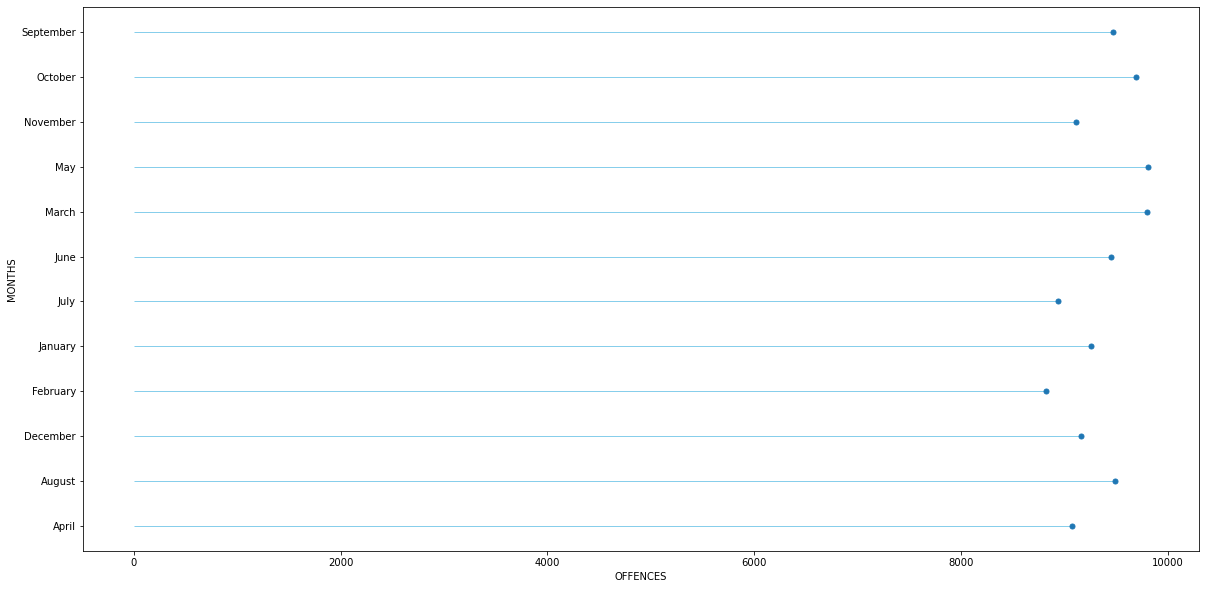

In [24]:
plt.rcParams['figure.figsize'] = (20,10)
plt.hlines(y= month[0], xmin=0, xmax=monthlyOffence, color='skyblue', linewidth=1)
plt.plot(monthlyOffence, month[0], "o", ms=5)
plt.xlabel('OFFENCES')
plt.ylabel('MONTHS')
plt.show()

In [26]:
def yearlyOffenceCountDaily(offence):
    # get all the Offence Level 2 Description with x name and drop the nulls
    perCrimeOffenceCount = pd.DataFrame(data.where(data["Offence Level 2 Description"] == offence).dropna())
    # record all unique dates 
    dates = pd.to_datetime(perCrimeOffenceCount['Reported Date'].unique())

    # add days to arry
    dayNumberArray = []
    # for day in dates add the dates to the array
    for i in dates:
        dayNumberArray.append(i.timetuple().tm_yday)
    # make sure the two arrays are the same length
    len(dayNumberArray)

    
    # get the reported months and the number of offences per day
    perCrimeOffenceCount = pd.DataFrame(perCrimeOffenceCount.groupby(pd.to_datetime(perCrimeOffenceCount['Reported Date']))['Offence count'].sum())
    # change sum to an array
    perCrimeOffenceCount = np.array(perCrimeOffenceCount['Offence count']).flatten()
    # make sure the two arrays are the same length
    len(perCrimeOffenceCount)
    joined = pd.DataFrame({'days': dayNumberArray, 'Offence count': perCrimeOffenceCount})
    return joined


In [96]:
# funciton to create a new colour
def randomColour():
     return (np.random.random(), np.random.random(), np.random.random())
monthColours = {
    "Jan": randomColour(),
    "Feb": randomColour(),
    "Mar": randomColour(),
    "Apr": randomColour(),
    "May": randomColour(),
    "Jun": randomColour(),
    "Jul": randomColour(),
    "Aug": randomColour(),
    "Sep": randomColour(),
    "Oct": randomColour(),
    "Nov": randomColour(),
    "Dec": randomColour()
}
dayOfMonthEnd = [30,58,89,119,150,180,211,242,272,303,333,365]

# Hexbin Plot 
The plots below show the frequency at which offences occured during the year for each offence *(theft and related offences property damage and environmental, acts intended to cause injury serious criminal trespass, fraud deception and related offences, other offences against the person, sexual assault and related offences, robbery and related offences homicide and related offences)* by day. Darker colours mean more offences occured during that day

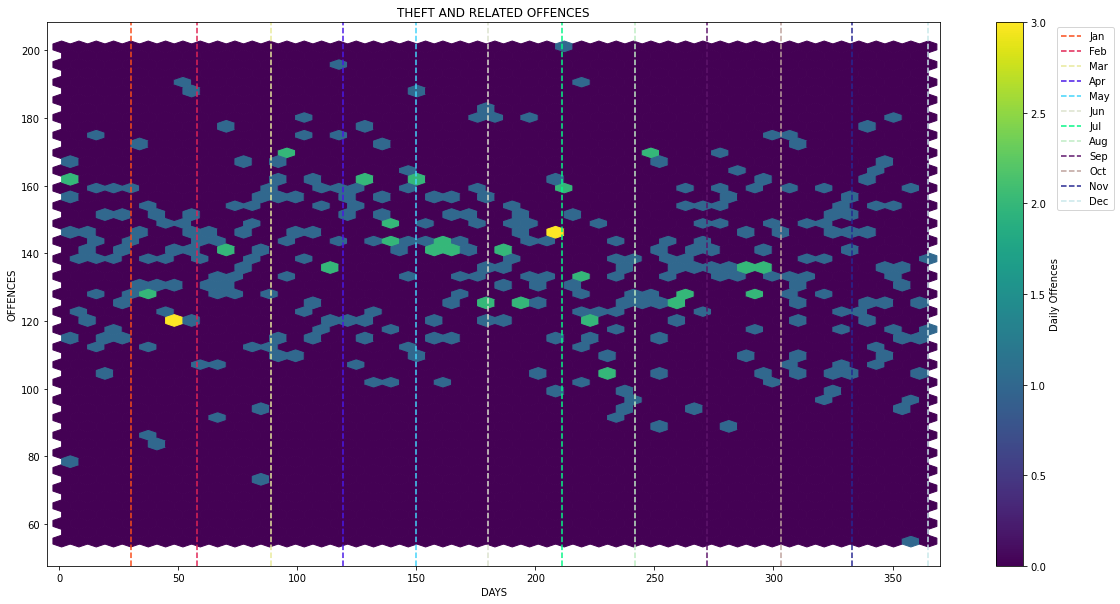

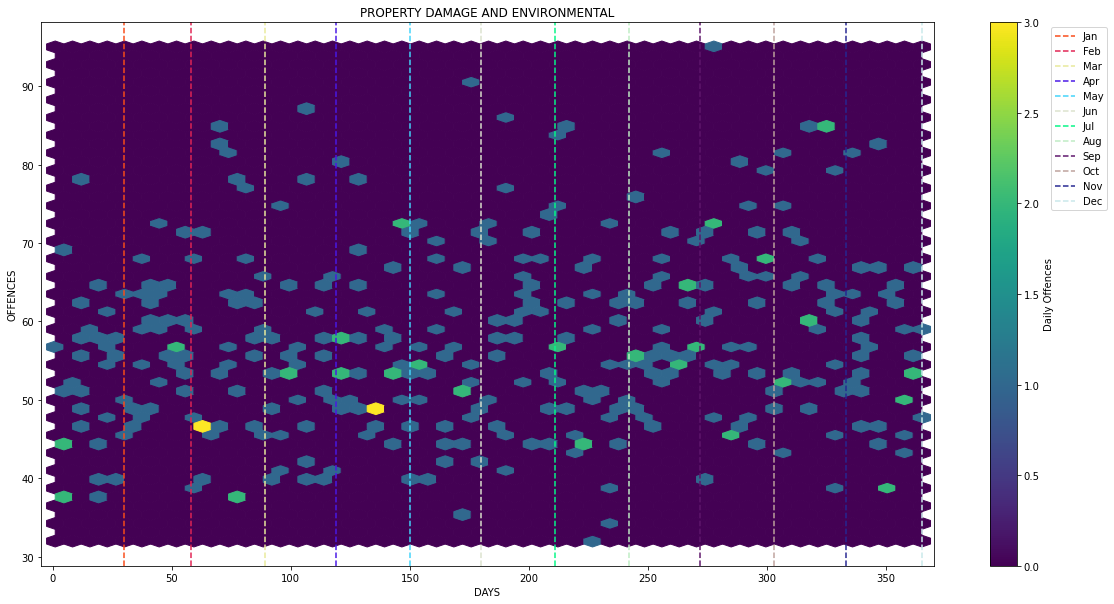

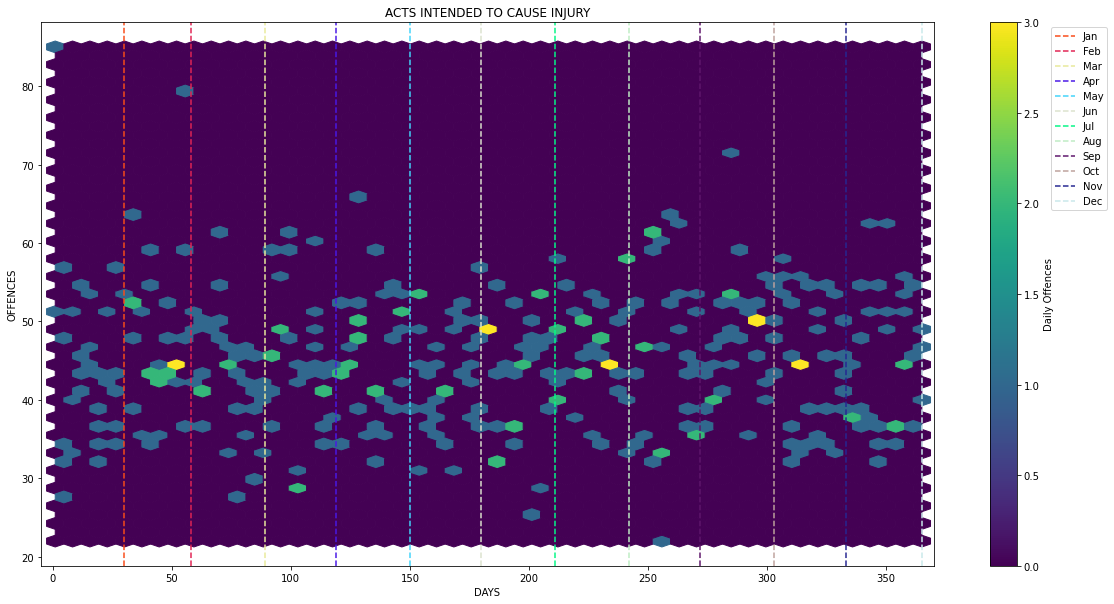

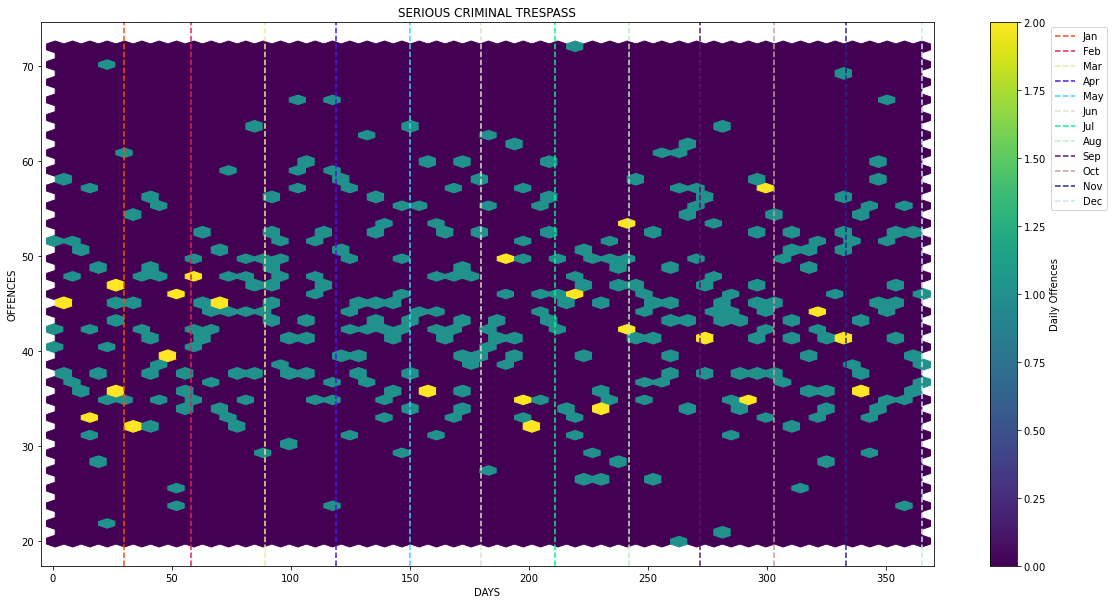

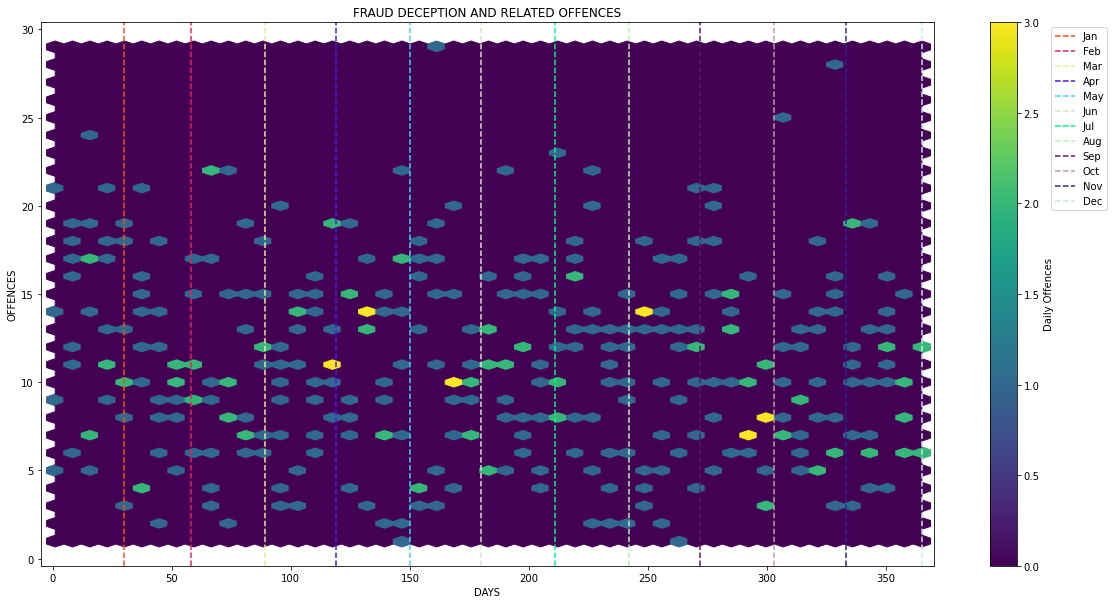

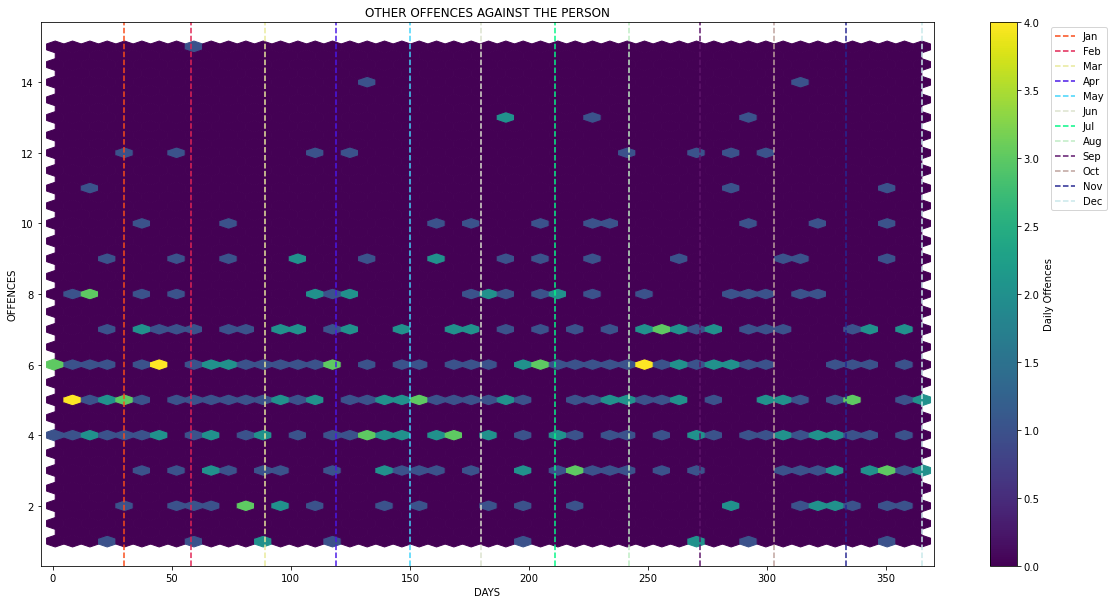

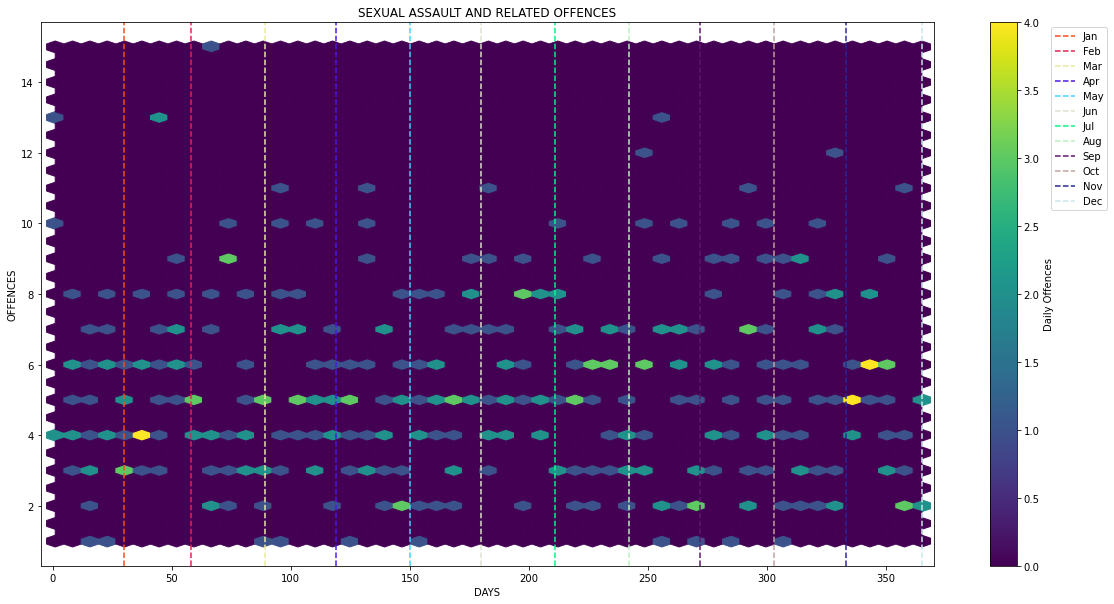

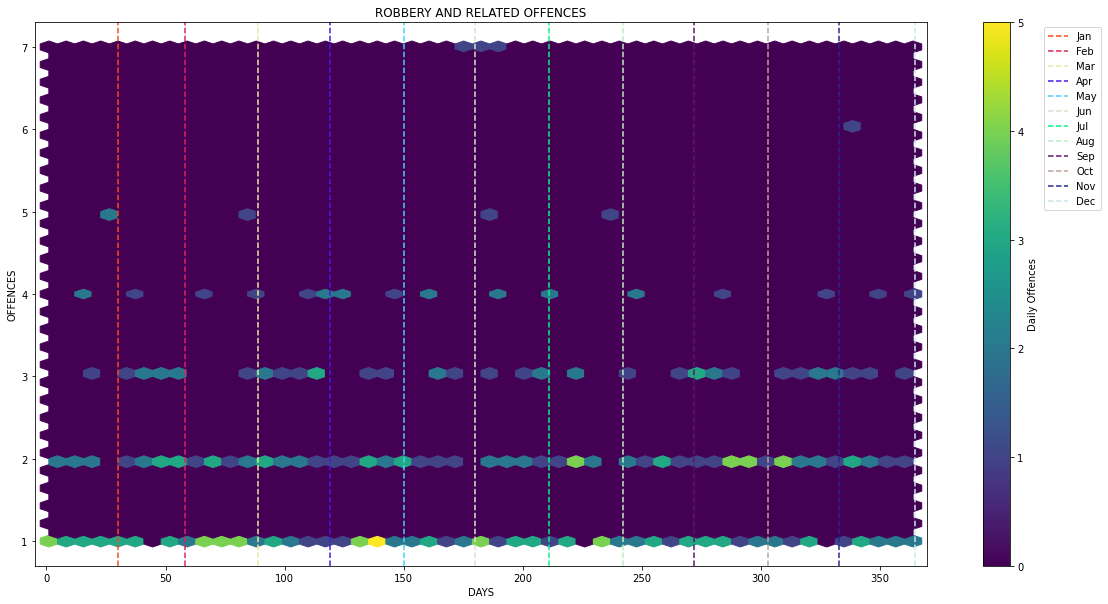

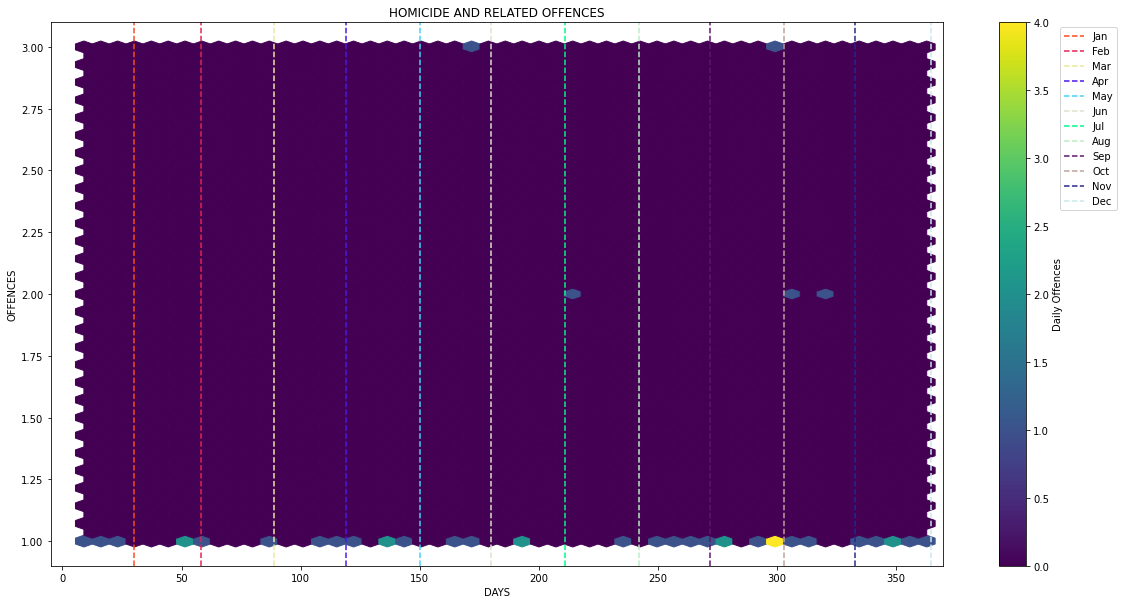

In [93]:
l2 = np.array((0, 30))
for offence in uniqueCrime:
    col = randomColour()
    offencePlot = yearlyOffenceCountDaily(offence)
    gradient = plt.hexbin(x = offencePlot['days'],y=offencePlot['Offence count'], gridsize = 50, cmap =plt.cm.get_cmap(plt.cm.viridis, 150)) 
    cb = plt.colorbar(gradient,label='Daily Offences') 
    plt.title(offence) 
    plt.ylabel('OFFENCES')
    plt.xlabel('DAYS')
    plt.xlim((-5, 370))
        
    plt.axvline(x=30, color = monthColours['Jan'], linestyle='--', label='Jan')
    plt.axvline(x=58, color= monthColours['Feb'], linestyle='--', label='Feb')
    plt.axvline(x=89, color= monthColours['Mar'], linestyle='--', label='Mar')
    plt.axvline(x=119, color= monthColours['Apr'], linestyle='--', label='Apr')
    plt.axvline(x=150, color= monthColours['May'], linestyle='--', label='May')
    plt.axvline(x=180, color= monthColours['Jun'], linestyle='--', label='Jun')
    plt.axvline(x=211, color= monthColours['Jul'], linestyle='--', label='Jul')
    plt.axvline(x=242, color= monthColours['Aug'], linestyle='--', label='Aug')
    plt.axvline(x=272, color= monthColours['Sep'], linestyle='--', label='Sep')
    plt.axvline(x=303, color= monthColours['Oct'], linestyle='--', label='Oct')
    plt.axvline(x=333, color= monthColours['Nov'], linestyle='--', label='Nov')
    plt.axvline(x=365, color= monthColours['Dec'], linestyle='--', label='Dec')
    
    plt.legend(bbox_to_anchor = (1.2, 1))
    plt.show()